# Estimating growth rate in the households model

In this notebook, we start by running the UK SEPIR households example and estimating the growth rate directly. We then look at ways we can estimate it without directly solving the equations.

In [1]:
from copy import deepcopy
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from numpy import arange, argmin, array, diag,  log, ones, where, zeros
from numpy.linalg import eig
from os.path import isfile
from pandas import read_csv
from pickle import load, dump
from scipy.integrate import solve_ivp
from scipy.sparse import eye, identity
from scipy.sparse import csc_matrix as sparse
from scipy.sparse.linalg import inv
from time import time as get_time
from model.preprocessing import (
        SEPIRInput, HouseholdPopulation, make_initial_condition)
from model.specs import TWO_AGE_SEPIR_SPEC, TWO_AGE_UK_SPEC
from model.common import SEPIRRateEquations
from model.imports import NoImportModel

In [2]:
from os import chdir, getcwd
current_dir = getcwd()
if current_dir[-9:] == 'tutorials':
    chdir('..')

The following block implements and solves the SEPIR model based on UK population parameters:

In [3]:
SPEC = {**TWO_AGE_SEPIR_SPEC, **TWO_AGE_UK_SPEC}

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()

model_input = SEPIRInput(SPEC, composition_list, comp_dist)

household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)

rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

H0 = make_initial_condition(household_population, rhs)

tspan = (0.0, 365)
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::5])
E = H.T.dot(household_population.states[:, 1::5])
P = H.T.dot(household_population.states[:, 2::5])
I = H.T.dot(household_population.states[:, 3::5])
R = H.T.dot(household_population.states[:, 4::5])
time_series = {
'time':time,
'S':S,
'E':E,
'P':P,
'I':I,
'R':R
}


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.37it/s]


In the next block, we plot the log of the mean "active" infections ($E+P+I$) over time, and the log of the total proportion of households containing an infection $H(\underline{X}:(E+P+I)(\underline{X})>0)$. Comparing the linear segment of these plots, we can see that during the exponential growth phase of the epidemic, the household growth rate is the same as the individual-level growth rate, exactly as predicted by theory.

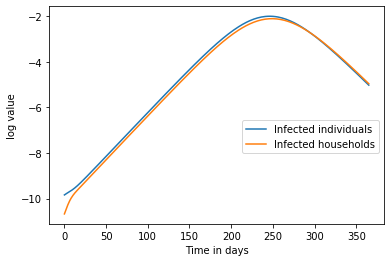

In [4]:
data_list = [time_series['S']/model_input.ave_hh_by_class,
    time_series['E']/model_input.ave_hh_by_class,
    time_series['P']/model_input.ave_hh_by_class,
    time_series['I']/model_input.ave_hh_by_class,
    time_series['R']/model_input.ave_hh_by_class]

log_infs = log((data_list[1]+data_list[2]+data_list[3]).sum(axis=1))
inf_states = where((rhs.states_exp_only + rhs.states_pro_only + rhs.states_inf_only).sum(axis=1)>0)[0]

fig, ax = subplots(1)

ax.plot(time, log_infs,label='Infected individuals')
ax.plot(time, log((H[inf_states]).sum(axis=0)),label='Infected households')
ax.set_xlabel('Time in days')
ax.set_ylabel('log value')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

By inspection of the plots, we can see that around day 50 the epidemic is definitely in its exponential growth phase. In the next box we work out which increment of the solver is closest to day 50, then directly calculate the gradient of the log growth curve at this time step, giving us an estimate of the exponential growth rate.

In [5]:
t_50 = argmin(abs(time - 50))
print('Closest time to 50 days is at increment',t_50,', t[',t_50,']=',time[t_50],'.')
r_guess = (log_infs[t_50+1]-log_infs[t_50])/(time[t_50+1]-time[t_50])
print('Direct estimate of log gradient at increment',t_50,'from population estimates is',r_guess,'.')
r_guess_hh = (log((H[inf_states,t_50+1]).sum(axis=0))-log((H[inf_states,t_50]).sum(axis=0)))/(time[t_50+1]-time[t_50])
print('Direct estimate of log gradient at increment',t_50,'from hh estimates is',r_guess_hh,'.')

Closest time to 50 days is at increment 49 , t[ 49 ]= 49.74861010465704 .
Direct estimate of log gradient at increment 49 from population estimates is 0.0383904111955741 .
Direct estimate of log gradient at increment 49 from hh estimates is 0.0386602586100241 .


## Growth rate calculations

We will use an Euler-Lotka approach to do growth rate calculations. Suppose we are in the exponential growth phase of our dynamics. Let $\underline{I}$ be the profile of households typed by composition and risk class of index case, i.e. if infectious households of type $i$ have composition $\underline{N}(i)$ and an index case in risk class $C(i)$, then $I_i$ is the proportion of infected households in this growth phase which are in composition $\underline{N}(i)$ and had their local outbreak seeded by a case in risk class $C(i)$. In the exponential growth phase, this grows according to
$$
\frac{\mathrm{d}\underline{I}}{\mathrm{d}t} = e^{rt}\underline{I}_*,
$$
where $\underline{I}_*$ is the profile of infectious households by composition and index case class at time $t=0$. If $\underline{\underline{\lambda}}(a)$ is the matrix with $(i,j)$th entry giving the rate at which a household of composition-seed type $i$ generates those of composition-seed type $j$ at time $a$ since its original import, then we get the following Euler-Lotka equation
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* e^{-r\underline{\underline{In}}t}\underline{\underline{\lambda}}\mathrm{d}t.
$$
Assuming we do not see repeat introductions of infection into a single household, we can decompose $\underline{\underline{\lambda}}$ as follows:
$$
\underline{\underline{\lambda}} = \underline{\underline{\alpha}}e^{\underline{\underline{Q}}_{\mathrm{int}}t}\underline{\underline{F}}\underline{\underline{P}}.
$$
Here $\underline{\underline{\alpha}}$ is the matrix mapping composition and import class of household to an initial condition in the households model, $\underline{\underline{F}}$ is infection rate to each class from each composition, and $\underline{\underline{P}}$ is probability that the infection kicked out to a given class ends up in a given type of household. The term $e^{\underline{\underline{Q}}_{\mathrm{int}}t}$ gives the evolution of the within-household system, derived from the fact that we are assuming that after an import there is no other interaction with external households, so the evolution is linear. The Euler-Lotka equation is then
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* \underline{\underline{\alpha}} e^{(underline{\underline{Q}}_{\mathrm{int}}-r\underline{\underline{In}})t}\underline{\underline{F}}\underline{\underline{P}}\mathrm{d}t,
$$
and integrating we get
$$
\underline{I}_* = \underline{I}_* \underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}.
$$
This is an eigenvector formula with eigenvalue 1, so to find the growth rate, we need to find $r$ such that the transpose of
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}
$$
has leading(?) eigenvalue 1 (cf Pellis, Ferguson and Fraser on households-workplaces models). Because $\underline{\underline{F}}$ scales linearly with the baseline between-household transmission, so estimate between-household transmission we just need to put in a guess, calculate the leading eigenvalue of the compound matrix, then scale the guess by the reciprocal of this eigenvalue to give us a between-household transmission rate which gives us the oberved growth rate. Alternatively, to calculate $r$ based on some parameters, we can just do something like interval bisection in 1D.

In the boxes below, we calculate all the components of this matrix for our UK SEPIR model example.

The following block creates a matrix `reverse_comp_dist` containing the probability that an individual in a given age class is in a household of a given composition - this is a component of our $\underline{\underline{P}}$ matrix.

In [6]:
no_risk_classes = composition_list.shape[1]

reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

In the following block, `Q_int` is internal evolution matrix, `FOI_by_state` gives expected infection kicked out by a household in a given state (the $\underline{\underline{F}}$ matrix).

In [7]:
Q_int = rhs.Q_int

FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))

for ic in range(rhs.no_inf_compartments):
            states_inf_only =  rhs.inf_by_state_list[ic]
            FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                    rhs.epsilon * states_inf_only.T)).T

In [8]:
index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

no_index_states = len(index_states)
comp_by_index_state = household_population.which_composition[index_states]

The next box creates $\underline{\underline{\alpha}}$

In [9]:
starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))

Next matrix is "probability that an index case in class c results in outbreak in index state i", i.e. $\underline{\underline{P}}$:

In [10]:
index_prob = zeros((no_risk_classes,no_index_states))
for i in range(no_index_states):
    index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
    index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]

The next box combines all this together to give us
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}.
$$

In [11]:
def get_multiplier(r, Q_int, FOI_by_state, index_prob, starter_mat):
    inv_diff = inv(r * identity(Q_int.shape[0]) - Q_int)
    step_1 = FOI_by_state.dot(index_prob)
    step_2 = inv_diff.dot(step_1)
    step_3 = starter_mat.dot(step_2)
    step_4 = step_3
    return step_4

In the boxes below, we empirically calculate the growth rate at each time increment and plot its value over time.

In [12]:
no_tsteps = len(time)
r_range = zeros(no_tsteps-1,)
for tstep in range(no_tsteps-1):
    r_range[tstep] = (log_infs[tstep+1]-log_infs[tstep])/(time[tstep+1]-time[tstep])

Text(0, 0.5, 'Empirical growth rate')

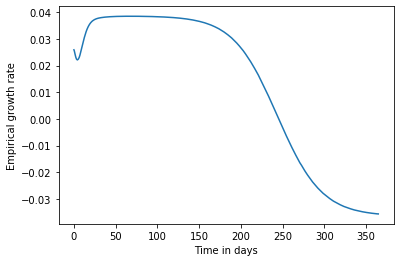

In [13]:
fig, ax = subplots(1)

ax.plot(time[:-1], r_range)
ax.set_xlabel('Time in days')
ax.set_ylabel('Empirical growth rate')

Now estimate the eigenvalue of the multiplier over time based on the growth rates calculated above - note that we need to take its transpose since we did the Euler-Lotka stuff with respect to column vectors.

In [14]:
short_len = int(no_tsteps/10)
multiplier_list = []
evals = zeros(short_len,)

start_time = get_time()

for i in range(short_len):
    multiplier_now = get_multiplier(r_range[10*i], Q_int, FOI_by_state, index_prob, starter_mat)
    multiplier_list.append(multiplier_now)
    evals[i] = eig(multiplier_now.T)[0][0]
    
    time_now = get_time()
    print(i,
          'of',
          short_len,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (short_len-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


0 of 25 calculations completed 9.824361801147461 seconds elapsed,estimated 235.78468322753906 seconds remaining.
1 of 25 calculations completed 19.88297748565674 seconds elapsed,estimated 228.6542410850525 seconds remaining.
2 of 25 calculations completed 29.84044361114502 seconds elapsed,estimated 218.82991981506348 seconds remaining.
3 of 25 calculations completed 39.73230242729187 seconds elapsed,estimated 208.59458774328232 seconds remaining.
4 of 25 calculations completed 49.764628887176514 seconds elapsed,estimated 199.05851554870605 seconds remaining.
5 of 25 calculations completed 59.71616840362549 seconds elapsed,estimated 189.10119994481406 seconds remaining.
6 of 25 calculations completed 69.71826100349426 seconds elapsed,estimated 179.27552829469954 seconds remaining.
7 of 25 calculations completed 79.69372415542603 seconds elapsed,estimated 169.3491638302803 seconds remaining.
8 of 25 calculations completed 89.64071798324585 seconds elapsed,estimated 159.3612764146593 seco

We now plot the leading eigenvalue of the multiplier.

Text(0, 0.5, 'Leading eigenvalue of multiplier')

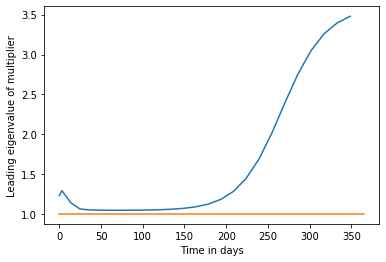

In [15]:
fig, ax = subplots(1)

ax.plot(time[10*arange(short_len)], evals)
ax.plot([time[0],time[-1]],[1,1])
ax.set_xlabel('Time in days')
ax.set_ylabel('Leading eigenvalue of multiplier')

This isn't quite equal to 1 in the exponential growth phase. Unclear currently whether this is a numerical error or an actual mistake.

## More experiments

In the following box we define a function which calculates the time series of eigenvalues for a given set of specs:

In [16]:
composition_list = array([[0,1],[0,2],[1,1],[1,2],[2,1],[2,2]])
comp_dist = (1/len(composition_list)) * ones(len(composition_list),)
no_risk_classes = composition_list.shape[1]
reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

def get_r_time_series_and_evals(spec):

    model_input = SEPIRInput(spec, composition_list, comp_dist)

    household_population = HouseholdPopulation(
            composition_list, comp_dist, model_input)

    rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

    H0 = make_initial_condition(household_population, rhs)

    tspan = (0.0, 150)
    solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

    time = solution.t
    H = solution.y
    S = H.T.dot(household_population.states[:, ::5])
    E = H.T.dot(household_population.states[:, 1::5])
    P = H.T.dot(household_population.states[:, 2::5])
    I = H.T.dot(household_population.states[:, 3::5])
    R = H.T.dot(household_population.states[:, 4::5])

    log_infs = log((E + P + I).sum(axis=1))
    no_tsteps = len(time)
    r_range = zeros(no_tsteps-1,)
    for tstep in range(no_tsteps-1):
        r_range[tstep] = (log_infs[tstep+1]-log_infs[tstep])/(time[tstep+1]-time[tstep])
        
    Q_int = rhs.Q_int

    FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))

    for ic in range(rhs.no_inf_compartments):
                states_inf_only =  rhs.inf_by_state_list[ic]
                FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                        rhs.epsilon * states_inf_only.T)).T
    
    index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

    no_index_states = len(index_states)
    comp_by_index_state = household_population.which_composition[index_states]
    
    starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))
    
    index_prob = zeros((no_risk_classes,no_index_states))
    for i in range(no_index_states):
        index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
        index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]
        
    short_len = int(no_tsteps/10)
    multiplier_list = []
    evals = zeros(short_len,)
    for j in range(short_len):
        multiplier_now = get_multiplier(r_range[10*j], Q_int, FOI_by_state, index_prob, starter_mat)
        multiplier_list.append(multiplier_now)
        eval_list = eig(multiplier_now.T)[0]
#         evals[j] = eval_list[argmin(abs(eval_list - ones(eval_list.shape)))]
        evals[j] = eval_list[0]
    
    return r_range, time, evals


We now calculate the eigenvalue time series for this simple small-households model over a range of household-level reproductive ratio ($R_*$) values:

In [17]:
r_range_list = []
time_list = []
eval_range_list = []

RG_range = arange(1.1,2,0.1)

no_steps = len(RG_range)
start_time = get_time()
for i in range(no_steps):
    RG_now = RG_range[i]
    spec = deepcopy(SPEC)
    spec['R*'] = RG_now
    r_now, t_now, evals_now = get_r_time_series_and_evals(spec)
    r_range_list.append(r_now)
    time_list.append(t_now)
    eval_range_list.append(evals_now)
    time_now = get_time()
    print(i,
          'of',
          no_steps,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (no_steps-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


0 of 9 calculations completed 1.9402165412902832 seconds elapsed,estimated 15.521732330322266 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.76it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


1 of 9 calculations completed 3.894071340560913 seconds elapsed,estimated 13.629249691963196 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.33it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


2 of 9 calculations completed 5.817801475524902 seconds elapsed,estimated 11.635602951049805 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


3 of 9 calculations completed 7.76739764213562 seconds elapsed,estimated 9.709247052669525 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.88it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


4 of 9 calculations completed 9.721224069595337 seconds elapsed,estimated 7.776979255676269 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.16it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


5 of 9 calculations completed 11.609004259109497 seconds elapsed,estimated 5.8045021295547485 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.61it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


6 of 9 calculations completed 13.62438154220581 seconds elapsed,estimated 3.8926804406302318 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.55it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


7 of 9 calculations completed 15.581783056259155 seconds elapsed,estimated 1.9477228820323944 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 66.79it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


8 of 9 calculations completed 17.604572296142578 seconds elapsed,estimated 0.0 seconds remaining.


Now plot the time series:

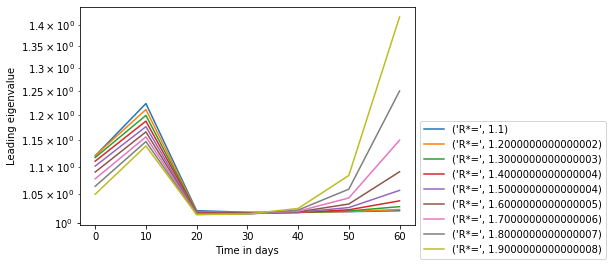

In [18]:
from matplotlib.pyplot import yscale

fig, ax = subplots(1)

for i in range(no_steps):
    ax.plot(10*arange(len(eval_range_list[i])), eval_range_list[i], label=('R*=',RG_range[i]))
yscale('log')
ax.set_ylabel('Leading eigenvalue')
ax.set_xlabel('Time in days')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

For all of the reproductive ratios, the eigenvalue settles around 1 during the exponential growth phase.

To do some more robust testing, we now define a function that generates a random set of parameters.

In [19]:
from numpy.random import rand

def draw_random_specs(spec):
    
    rand_spec = deepcopy(spec)
    rand_spec['AR'] = 0.25 + 0.5*rand(1,) # SAR between 0.25 and 0.75
    rand_spec['R*'] = 1 + rand(1,) # R* between 1 and 2
    rand_spec['recovery_rate'] = 1/(1 + 7 * rand(1,)) # Fix inf period between 1 and 7 days
    rand_spec['incubation_rate'] = 1/(1 + 9 * rand(1)) # Fix inc period between 1 and 10 days
    rand_spec['symp_onset_rate'] = 1/(1 + 5 * rand(1)) # Fix prodromal period between 1 and 5 days
    rand_spec['prodromal_trans_scaling'] = rand(no_risk_classes,) # Random prodrome scalings <1
    unscaled_sus = rand(no_risk_classes,)
    rand_spec['sus'] = unscaled_sus/unscaled_sus.max() # Set sus of most sus class to 1, all others <1
    rand_spec['density_expo'] = rand(1,)
    
    return rand_spec

Now carry out the eigenvalue calculations for 50 of these parameter sets, and plot the resulting eigenvalue time series.

In [20]:
no_samples = 50

r_range_list = []
time_list = []
eval_range_list = []

start_time = get_time()
for i in range(no_samples):
    spec = draw_random_specs(SPEC)
    r_now, t_now, evals_now = get_r_time_series_and_evals(spec)
    r_range_list.append(r_now)
    time_list.append(t_now)
    eval_range_list.append(evals_now)
    time_now = get_time()
    print(i,
          'of',
          no_samples,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (no_samples-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.38it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


0 of 50 calculations completed 2.3756165504455566 seconds elapsed,estimated 116.40521097183228 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.78it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


1 of 50 calculations completed 5.68193507194519 seconds elapsed,estimated 136.36644172668457 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.78it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


2 of 50 calculations completed 7.631943941116333 seconds elapsed,estimated 119.56712174415588 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


3 of 50 calculations completed 11.028604507446289 seconds elapsed,estimated 126.82895183563232 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.45it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


4 of 50 calculations completed 14.231778144836426 seconds elapsed,estimated 128.08600330352783 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.19it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


5 of 50 calculations completed 18.420418739318848 seconds elapsed,estimated 135.08307075500488 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.94it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


6 of 50 calculations completed 20.026498317718506 seconds elapsed,estimated 123.01991823741368 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.11it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


7 of 50 calculations completed 23.66322898864746 seconds elapsed,estimated 124.23195219039917 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.49it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


8 of 50 calculations completed 26.76157855987549 seconds elapsed,estimated 121.91385788387723 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.37it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


9 of 50 calculations completed 28.320791721343994 seconds elapsed,estimated 113.28316688537598 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 87.41it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


10 of 50 calculations completed 29.79857349395752 seconds elapsed,estimated 105.64948784221302 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.56it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


11 of 50 calculations completed 32.21377372741699 seconds elapsed,estimated 102.01028347015381 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 70.33it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


12 of 50 calculations completed 34.62083625793457 seconds elapsed,estimated 98.53622627258301 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 87.00it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


13 of 50 calculations completed 37.989967346191406 seconds elapsed,estimated 97.68848746163505 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.03it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


14 of 50 calculations completed 39.729963302612305 seconds elapsed,estimated 92.70324770609538 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.79it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


15 of 50 calculations completed 43.393986225128174 seconds elapsed,estimated 92.21222072839737 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


16 of 50 calculations completed 45.58405804634094 seconds elapsed,estimated 88.48670091348536 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.71it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


17 of 50 calculations completed 47.93739199638367 seconds elapsed,estimated 85.22203021579318 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 65.94it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


18 of 50 calculations completed 49.72591543197632 seconds elapsed,estimated 81.13175675743504 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 64.28it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


19 of 50 calculations completed 53.85653495788574 seconds elapsed,estimated 80.78480243682861 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.81it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


20 of 50 calculations completed 56.82150602340698 seconds elapsed,estimated 78.46779403232392 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.38it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


21 of 50 calculations completed 59.045204639434814 seconds elapsed,estimated 75.14844226837158 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 86.28it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


22 of 50 calculations completed 60.43252754211426 seconds elapsed,estimated 70.94253233204718 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


23 of 50 calculations completed 63.676300287246704 seconds elapsed,estimated 68.98265864451726 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.27it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


24 of 50 calculations completed 65.51793837547302 seconds elapsed,estimated 65.51793837547302 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.66it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


25 of 50 calculations completed 67.81963086128235 seconds elapsed,estimated 62.60273617964525 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 86.88it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


26 of 50 calculations completed 71.73826909065247 seconds elapsed,estimated 61.110377373518766 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


27 of 50 calculations completed 74.1689121723175 seconds elapsed,estimated 58.27557384967804 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 72.30it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


28 of 50 calculations completed 76.23972487449646 seconds elapsed,estimated 55.208076633256056 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.05it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


29 of 50 calculations completed 79.05312514305115 seconds elapsed,estimated 52.70208342870077 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.00it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


30 of 50 calculations completed 81.67260265350342 seconds elapsed,estimated 50.057401626340805 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.13it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


31 of 50 calculations completed 84.05576086044312 seconds elapsed,estimated 47.28136548399925 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.94it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


32 of 50 calculations completed 85.6537778377533 seconds elapsed,estimated 44.12467343156988 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


33 of 50 calculations completed 88.74992942810059 seconds elapsed,estimated 41.76467267204733 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.32it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


34 of 50 calculations completed 90.59107184410095 seconds elapsed,estimated 38.824745076043264 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.77it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


35 of 50 calculations completed 93.47761487960815 seconds elapsed,estimated 36.35240578651428 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.61it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


36 of 50 calculations completed 97.21376276016235 seconds elapsed,estimated 34.15618691573272 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.27it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


37 of 50 calculations completed 100.48683452606201 seconds elapsed,estimated 31.732684587177477 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.36it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


38 of 50 calculations completed 102.80189299583435 seconds elapsed,estimated 28.995405716773792 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.75it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


39 of 50 calculations completed 105.03493022918701 seconds elapsed,estimated 26.258732557296753 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.80it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


40 of 50 calculations completed 106.85068416595459 seconds elapsed,estimated 23.455028231551008 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.61it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


41 of 50 calculations completed 109.29804039001465 seconds elapsed,estimated 20.81867436000279 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 68.88it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


42 of 50 calculations completed 112.25486707687378 seconds elapsed,estimated 18.274048128793407 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.98it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


43 of 50 calculations completed 114.4889087677002 seconds elapsed,estimated 15.612123922868209 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.18it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


44 of 50 calculations completed 117.00466132164001 seconds elapsed,estimated 13.000517924626669 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.82it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


45 of 50 calculations completed 119.30348467826843 seconds elapsed,estimated 10.374216058979863 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.47it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


46 of 50 calculations completed 122.76985192298889 seconds elapsed,estimated 7.836373526999291 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.99it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


47 of 50 calculations completed 124.49478125572205 seconds elapsed,estimated 5.187282552321752 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.22it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


48 of 50 calculations completed 126.05151271820068 seconds elapsed,estimated 2.5724798513918508 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.42it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


49 of 50 calculations completed 129.50047659873962 seconds elapsed,estimated 0.0 seconds remaining.


Text(0.5, 0, 'Time in days')

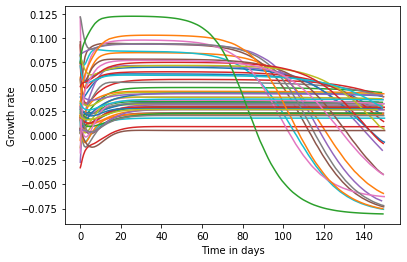

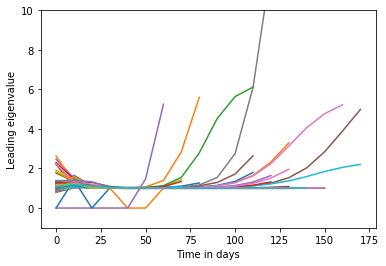

In [21]:
fig, ax = subplots(1)

for i in range(no_samples):
    ax.plot(time_list[i][:-1], r_range_list[i])
ax.set_ylabel('Growth rate')
ax.set_xlabel('Time in days')

fig, ax = subplots(1)

for i in range(no_samples):
    ax.plot(10*arange(len(eval_range_list[i])), eval_range_list[i])
ax.set_ylim([-1,10])
ax.set_ylabel('Leading eigenvalue')
ax.set_xlabel('Time in days')

Because we have not directly checked all of the parameter sets, there may be "bad" parameter sets samples which lead to strange behaviours in the model, although in theory all of them should allow for a sustained outbreak of infection. You should find that in the plot, most of the trajectories appear to settle around one during the period in their dynamics where the growth rate is constant.

## Calculating growth rate from model parameters

The tests above suggest that the eigenvector equation we have identified holds; if we measure the growth rate $r$ during the exponential growth phase, then the leading eigenvalue of the compound matrix comes out as 1.

In [22]:
SPEC = {**TWO_AGE_SEPIR_SPEC, **TWO_AGE_UK_SPEC}

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()
no_risk_classes = composition_list.shape[1]
reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

model_input = SEPIRInput(SPEC, composition_list, comp_dist)

household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)

rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.16it/s]


In [23]:
def estimate_growth_rate(household_population,rhs,interval=[0.01,0.1],tol=1e-3):
    
    Q_int = rhs.Q_int
    FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))
    for ic in range(rhs.no_inf_compartments):
                states_inf_only =  rhs.inf_by_state_list[ic]
                FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                        rhs.epsilon * states_inf_only.T)).T
    index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

    no_index_states = len(index_states)
    comp_by_index_state = household_population.which_composition[index_states]
    
    starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))
    
    index_prob = zeros((no_risk_classes,no_index_states))
    for i in range(no_index_states):
        index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
        index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]
        
    r_min = interval[0]
    r_max = interval[1]
    multiplier = get_multiplier(r_min, Q_int, FOI_by_state, index_prob, starter_mat)
    eval_min = eig(multiplier.T)[0][0]
    print('eval at min=',eval_min)
    multiplier = get_multiplier(r_max, Q_int, FOI_by_state, index_prob, starter_mat)
    eval_max = eig(multiplier.T)[0][0]
    print('eval at max=',eval_max)
    
    if ((eval_min-1) * (eval_max-1) > 0):
        print('Solution not contained within interval')
        return None

    while (r_max - r_min > tol):
        r_now = 0.5 * (r_max + r_min)
        multiplier = get_multiplier(r_now, Q_int, FOI_by_state, index_prob, starter_mat)
        eval_now = eig(multiplier.T)[0][0]
        print('eval at r =',r_now,'is',eval_now)
        if ((eval_now-1) * (eval_max-1) > 0):
            r_max = r_now
        else:
            r_min = r_now
    
    return r_now

In [24]:
r_est = estimate_growth_rate(household_population,rhs)

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.5459497483476308+0j)
eval at max= (0.5417507825899424+0j)
eval at r = 0.055 is (0.8579530748862363+0j)
eval at r = 0.0325 is (1.128451793155857+0j)
eval at r = 0.04375 is (0.9795852917096448+0j)
eval at r = 0.038125 is (1.0501437840626455+0j)
eval at r = 0.0409375 is (1.0139607658437342+0j)
eval at r = 0.04234375 is (0.9965546192292232+0j)
eval at r = 0.041640625 is (1.0052021727737501+0j)


In [25]:
H0 = make_initial_condition(household_population, rhs)

tspan = (0.0, 365)
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::5])
E = H.T.dot(household_population.states[:, 1::5])
P = H.T.dot(household_population.states[:, 2::5])
I = H.T.dot(household_population.states[:, 3::5])
R = H.T.dot(household_population.states[:, 4::5])
time_series = {
'time':time,
'S':S,
'E':E,
'P':P,
'I':I,
'R':R
}

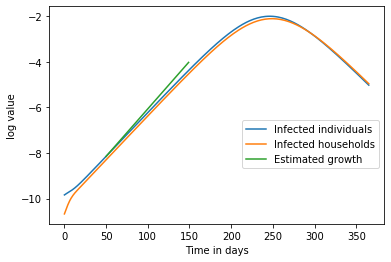

In [26]:
data_list = [time_series['S']/model_input.ave_hh_by_class,
    time_series['E']/model_input.ave_hh_by_class,
    time_series['P']/model_input.ave_hh_by_class,
    time_series['I']/model_input.ave_hh_by_class,
    time_series['R']/model_input.ave_hh_by_class]

log_infs = log((data_list[1]+data_list[2]+data_list[3]).sum(axis=1))
inf_states = where((rhs.states_exp_only + rhs.states_pro_only + rhs.states_inf_only).sum(axis=1)>0)[0]

t_50 = argmin(abs(time - 50))
t_150 = argmin(abs(time - 150))
log_inf_est = log_infs[t_50] + r_est * (time[t_50:t_150] - time[t_50])

fig, ax = subplots(1)

ax.plot(time, log_infs,label='Infected individuals')
ax.plot(time, log((H[inf_states]).sum(axis=0)),label='Infected households')
ax.plot(time[t_50:t_150], log_inf_est, label='Estimated growth')
ax.set_xlabel('Time in days')
ax.set_ylabel('log value')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

Our method slightly overestimates the growth rate.

## Estimating between-household mixing from a growth rate

Given a growth rate $r$, we can estimate the compound matrix
$$
\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{F}}\underline{\underline{P}}.
$$
Because $\underline{\underline{F}}$, the "force of infection" matrix, is linear in the baseline between-household mixing rate, we can rewrite the matrix as
$$
\beta_G\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{\tilde{F}}}\underline{\underline{P}}.
$$
where $\beta_G$ is the between-household mixing rate. Hence, to estimate this rate, we calculate
$$
\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{\tilde{F}(1)}}\underline{\underline{P}}.
$$
where $\underline{\underline{\tilde{F}}}(1)$ is the force of infection matrix calculated with $\beta_G$ fixed at 1, calculate its leading eigenvalue $\lambda$, and then set
$$
\beta_G = 1/\lambda.
$$